# 이미지 생성 테스트

In [7]:
import os, re, torch
import torch.nn as nn
from torchvision.utils import save_image

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim    = 128
ngf      = 64
out_ch   = 3
n        = 64
out_dir  = "samples_128"; os.makedirs(out_dir, exist_ok=True)

# 학습 때와 동일한 Generator
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, z_dim=128, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf//2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.main(z)

def strip_module(sd):
    return {re.sub(r"^module\.", "", k): v for k, v in sd.items()}

def load_G_only(ckpt_path, netG, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    # 네 save 포맷: {"epoch","step","G","D","optG","optD","cfg"}
    sd = ckpt["G"]
    if hasattr(sd, "state_dict"):
        sd = sd.state_dict()
    sd = strip_module(sd)
    netG.load_state_dict(sd, strict=True)
    return ckpt.get("epoch", 0), ckpt.get("step", 0)

# 최신 ckpt 잡기 (네 로직과 호환)
def latest_ckpt_path(save_dir):
    import glob
    from pathlib import Path
    cand = sorted(glob.glob(os.path.join(save_dir, "ckpt_e*_s*.pt")))
    if cand: return cand[-1]
    lat = os.path.join(save_dir, "latest.txt")
    if os.path.exists(lat):
        p = Path(lat).read_text().strip()
        return p if os.path.exists(p) else None
    return None

CKPT_DIR = "/content/drive/MyDrive/dcgan/dcgan_portraits128/ckpts"  # 네 경로로 바꿔
ckpt_path = latest_ckpt_path(CKPT_DIR)
assert ckpt_path, "체크포인트 못 찾음"

netG = Generator(z_dim=z_dim, ngf=ngf, nc=out_ch).to(device)
load_G_only(ckpt_path, netG, device)
netG.eval()
torch.manual_seed(1234)

with torch.no_grad():
    z = torch.randn(n, z_dim, 1, 1, device=device)
    fake = netG(z)  # [-1,1]
    save_image(fake, os.path.join(out_dir, "grid.png"),
               nrow=8, normalize=True, value_range=(-1,1))


# 학습 데이터


In [17]:
import os, re, random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageOps
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

## 가짜 이미지 생성

In [14]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, ngf=64, nc=3):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf//2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.main(z)

def strip_module(sd):
    return {re.sub(r"^module\.", "", k): v for k, v in sd.items()}

def load_G_only(ckpt_path, netG, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    sd = ckpt.get("G", ckpt)
    if hasattr(sd, "state_dict"):
        sd = sd.state_dict()
    netG.load_state_dict(strip_module(sd), strict=True)
    return int(ckpt.get("epoch", 0)), int(ckpt.get("step", 0))

@torch.no_grad()
def generate_fakes(ckpt_path, out_dir, n=300, z_dim=128, ngf=64,
                   batch_size=64, start_idx=0, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(out_dir, exist_ok=True)
    netG = Generator(z_dim=z_dim, ngf=ngf, nc=3).to(device).eval()
    load_G_only(ckpt_path, netG, device)

    remain, idx = n, start_idx
    while remain > 0:
        b = min(batch_size, remain)
        z = torch.randn(b, z_dim, 1, 1, device=device)
        fake = netG(z)  # [-1,1]
        for i in range(b):
            path = os.path.join(out_dir, f"fake_{idx:06d}.png")
            save_image(fake[i], path, normalize=True, value_range=(-1, 1))
            idx += 1
        remain -= b

# 여기에 네 경로/개수 넣고 그냥 호출
ckpt_path = "/content/drive/MyDrive/dcgan/dcgan_portraits128/ckpts/ckpt_e1030_s091670.pt"  # 파일 경로
out_dir   = "/content/drive/MyDrive/dcgan/fakes_128"                                        # 저장 폴더
generate_fakes(ckpt_path, out_dir, n=300, z_dim=128, ngf=64, batch_size=64)


## 진짜 이미지 가져오기

In [15]:
# 랜덤 300장 샘플링해서 128x128 PNG로 저장
SRC_DIR = Path("/content/drive/MyDrive/dcgan/datasets/Images")  # 원본
DST_DIR = Path("/content/drive/MyDrive/dcgan/resnet/real_128")         # 저장할 곳
N = 300
SEED = 42

DST_DIR.mkdir(parents=True, exist_ok=True)

# 허용 확장자
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
all_imgs = [p for p in SRC_DIR.rglob("*") if p.suffix.lower() in exts]
if not all_imgs:
    raise RuntimeError(f"이미지 없음: {SRC_DIR}")

random.seed(SEED)
pick = random.sample(all_imgs, k=min(N, len(all_imgs)))

def to_128_square(img: Image.Image) -> Image.Image:
    # EXIF 회전 보정 → 중앙 크롭으로 정사각 → 128 리사이즈
    img = ImageOps.exif_transpose(img.convert("RGB"))
    img = ImageOps.fit(img, (128, 128), method=Image.LANCZOS, centering=(0.5, 0.5))
    return img

for i, src in enumerate(pick):
    with Image.open(src) as im:
        out = to_128_square(im)
    out.save(DST_DIR / f"real_{i:06d}.png")  # PNG로 통일

len(os.listdir(DST_DIR))

300

# 분류기 학습 및 결과

### 설정

In [18]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

ROOT = "/content/drive/MyDrive/dcgan/resnet"   # real_128 / fakes_128 가 들어있는 상위 폴더
IMG  = 128
BATCH= 32
EPOCHS = 12
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_BEST = "/content/drive/MyDrive/dcgan/resnet/resnet_clf_best.pt"

### Transforms

In [19]:
train_tf = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.08, contrast=0.08, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1,1] 정규화
])
val_tf = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

### Dataset & Stratified split

In [20]:
full_ds = datasets.ImageFolder(ROOT)  # subfolders = classes
y = np.array(full_ds.targets)
idx = np.arange(len(full_ds))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(idx, y))

train_ds = Subset(datasets.ImageFolder(ROOT, transform=train_tf), train_idx)
val_ds   = Subset(datasets.ImageFolder(ROOT, transform=val_tf),   val_idx)

train_ld = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

class_names = datasets.ImageFolder(ROOT).classes  # ['fakes_128', 'real_128']
print("classes:", class_names)

classes: ['fakes_128', 'real_128']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 모델

In [21]:
# ResNet18 + ImageNet 사전학습 가중치 → 마지막 FC만 2클래스로
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2)
model = model.to(DEVICE)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.Adam(model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


### 학습루프

In [22]:
def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    probs_all, y_all = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = crit(logits, y)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        # 확률(softmax) 저장: class 1('real_128') 기준
        p = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        probs_all.append(p); y_all.append(y.detach().cpu().numpy())
    loss_avg = loss_sum / total
    acc = correct / total
    probs_all = np.concatenate(probs_all)
    y_all = np.concatenate(y_all)
    return loss_avg, acc, probs_all, y_all

history = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[]}
best_va = -1

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_ld, train=True)
    va_loss, va_acc, va_probs, va_y = run_epoch(val_ld,   train=False)
    sched.step()

    history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
    history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)

    if va_acc > best_va:
        best_va = va_acc
        torch.save({"model": model.state_dict(), "classes": class_names}, SAVE_BEST)
    print(f"[{ep:02d}] train {tr_acc:.3f}/{tr_loss:.3f}  val {va_acc:.3f}/{va_loss:.3f}  lr {sched.get_last_lr()[0]:.2e}")

print("best val acc:", best_va)

[01] train 0.917/0.197  val 0.967/0.086  lr 2.95e-04
[02] train 0.971/0.063  val 0.975/0.098  lr 2.80e-04
[03] train 0.994/0.020  val 0.925/0.153  lr 2.56e-04
[04] train 0.992/0.023  val 0.967/0.111  lr 2.25e-04
[05] train 0.996/0.012  val 0.975/0.042  lr 1.89e-04
[06] train 1.000/0.004  val 0.983/0.042  lr 1.50e-04
[07] train 1.000/0.002  val 0.992/0.042  lr 1.11e-04
[08] train 1.000/0.001  val 0.983/0.043  lr 7.50e-05
[09] train 1.000/0.002  val 0.983/0.039  lr 4.39e-05
[10] train 1.000/0.001  val 0.975/0.040  lr 2.01e-05
[11] train 1.000/0.001  val 0.975/0.036  lr 5.11e-06
[12] train 1.000/0.001  val 0.975/0.041  lr 0.00e+00
best val acc: 0.9916666666666667


## 결과

### Evaluation (best model)

In [23]:
best = torch.load(SAVE_BEST, map_location=DEVICE)
model.load_state_dict(best["model"]); model.eval()

# val set 다시 한 번 추론
_, _, probs, y_true = run_epoch(val_ld, train=False)
y_pred = (probs >= 0.5).astype(int)

# 리포트
print("\nClassification report (label 0=fakes, 1=real):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Classification report (label 0=fakes, 1=real):
              precision    recall  f1-score   support

   fakes_128      1.000     0.983     0.992        60
    real_128      0.984     1.000     0.992        60

    accuracy                          0.992       120
   macro avg      0.992     0.992     0.992       120
weighted avg      0.992     0.992     0.992       120



### 시각화

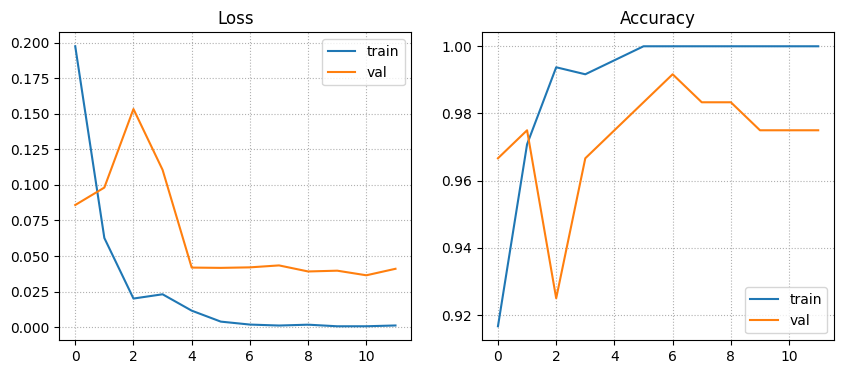

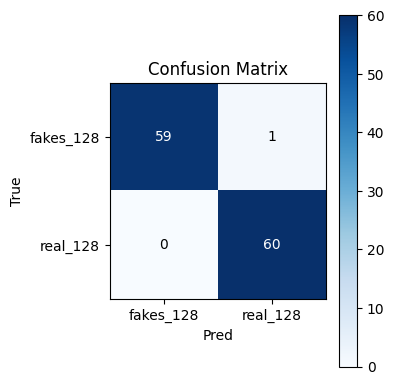

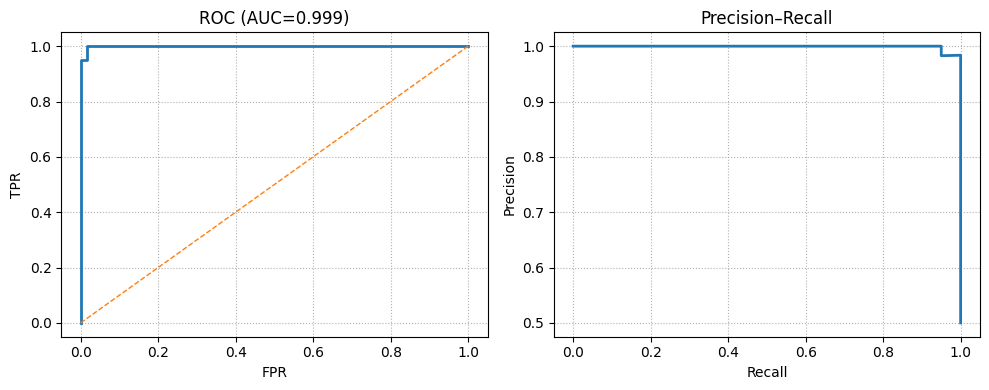

In [24]:
def plot_curves(history):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(history["tr_loss"], label="train")
    ax[0].plot(history["va_loss"], label="val")
    ax[0].set_title("Loss"); ax[0].legend(); ax[0].grid(True, ls=":")
    ax[1].plot(history["tr_acc"], label="train")
    ax[1].plot(history["va_acc"], label="val")
    ax[1].set_title("Accuracy"); ax[1].legend(); ax[1].grid(True, ls=":")
    plt.show()

def plot_confusion(y_true, y_pred, labels):
    from itertools import product
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Pred')
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.title("Confusion Matrix")
    plt.tight_layout(); plt.show()

def plot_roc_pr(y_true, probs):
    # positive class = 1 (real)
    auc = roc_auc_score(y_true, probs)
    fpr, tpr, _ = roc_curve(y_true, probs)
    prec, rec, _ = precision_recall_curve(y_true, probs)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--', lw=1)
    plt.title(f"ROC (AUC={auc:.3f})"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(ls=":")
    plt.subplot(1,2,2)
    plt.plot(rec, prec, lw=2)
    plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(ls=":")
    plt.tight_layout(); plt.show()

plot_curves(history)
plot_confusion(y_true, y_pred, class_names)
plot_roc_pr(y_true, probs)

### Sample predictions grid

In [26]:
# ===== 샘플 예측 그리드(깨끗한 버전) =====
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# 시각화용 역정규화: [-1,1] -> [0,1]
inv_norm = transforms.Normalize(mean=[-1]*3, std=[2]*3)  # (x*0.5+0.5)

val_preproc = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

@torch.no_grad()
def show_val_samples(full_ds, val_idx, model, class_names, n=16, seed=42):
    rng = np.random.RandomState(seed)
    picks = rng.choice(val_idx, size=min(n, len(val_idx)), replace=False)

    cols = 4
    rows = int(np.ceil(len(picks) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.ravel()

    model.eval()
    for k, ax in enumerate(axes[:len(picks)]):
        i = int(picks[k])
        path, gt = full_ds.samples[i]

        # 1) 시각화용 이미지
        pil = Image.open(path).convert("RGB").resize((IMG, IMG))
        vis = transforms.ToTensor()(pil)                  # [0,1]
        vis = vis.numpy().transpose(1, 2, 0)              # HWC

        # 2) 모델 입력
        x = val_preproc(pil).unsqueeze(0).to(DEVICE)      # 1x3x128x128
        logits = model(x)
        p_real = torch.softmax(logits, dim=1)[0, 1].item()
        pred = int(logits.argmax(1).item())

        ax.imshow(vis)
        ax.set_title(f"gt={class_names[gt]}\np_real={p_real:.2f} pred={class_names[pred]}")
        ax.axis("off")

    # 빈 칸 있으면 숨김
    for ax in axes[len(picks):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


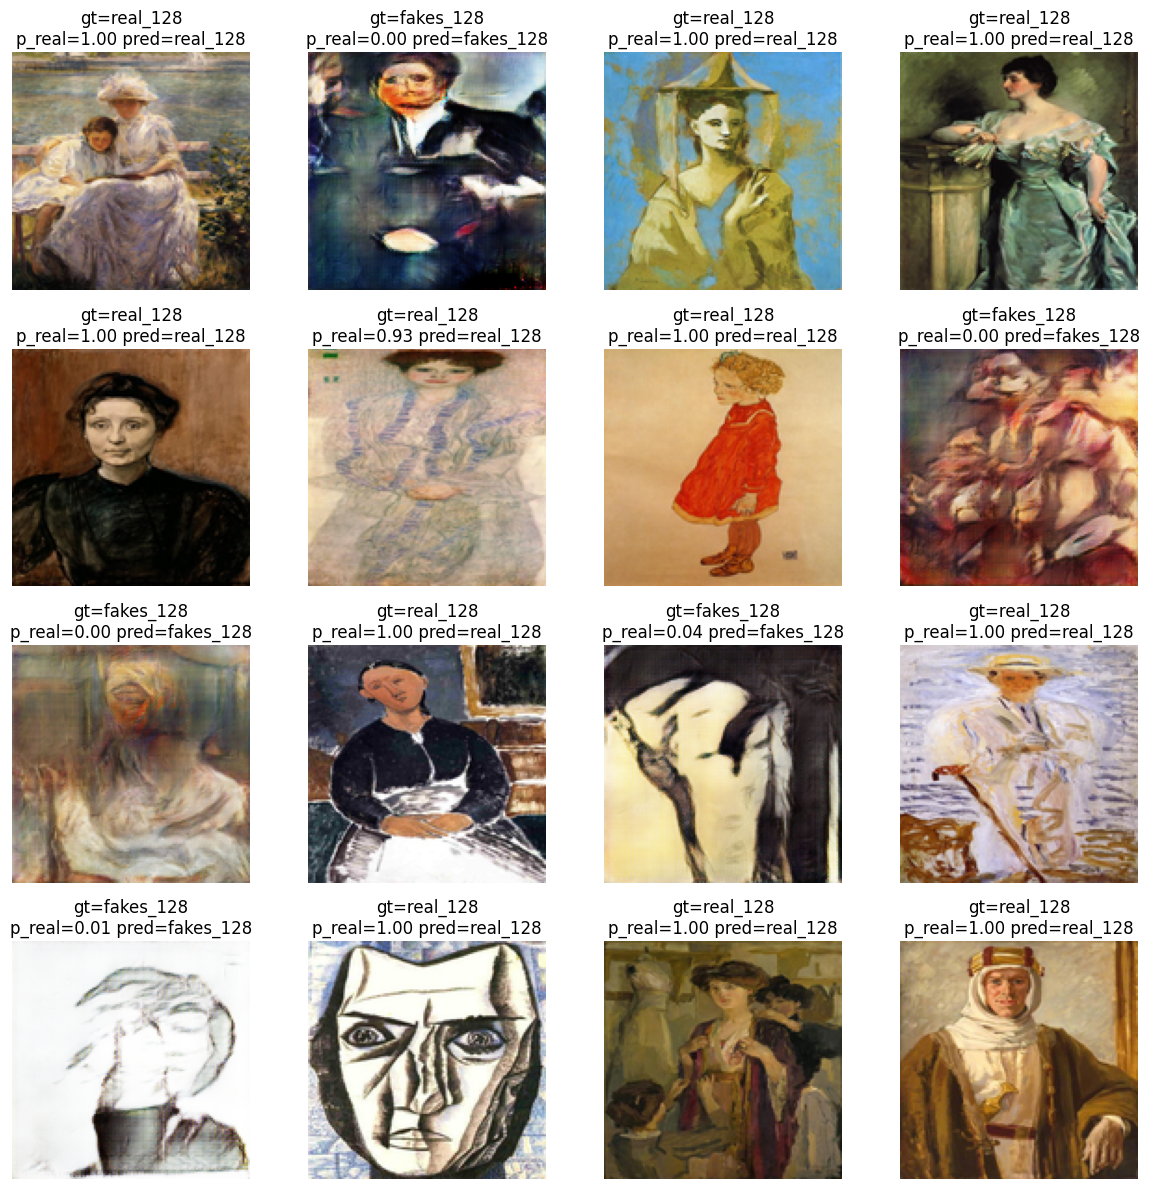

In [27]:
show_val_samples(full_ds, val_idx, model, class_names, n=16)
